In [1]:
import os
import re
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List
from collections import Counter

In [7]:
def extract_token_before_wait(
    response_dir: str = "./long_responses2",
    hidden_state_dir: str = "./long_hidden_state2",
    model_name: str = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    last_token_before_wait = []
    last_token_before_wo_wait = []
    for idx, path in enumerate(tqdm(os.listdir(response_dir))):
        with open(os.path.join(response_dir, path), "r") as f:
            response = json.load(f)
        # hidden_states = torch.load(
        #     os.path.join(hidden_state_dir, path.split(".")[0] + ".pt")
        # )
        input_ids = tokenizer(response["response"], return_tensors="pt")[
            "input_ids"
        ].to("cuda:0")
        # problem_length = tokenizer(response["problem"], return_tensors="pt")[
        #     "input_ids"
        # ].shape[1]
        # input_length = input_ids.shape[1]
        wait_word = ["wait", "Wait", " wait", " Wait"]
        wait_list = []
        for word in wait_word:
            wait_list.append(
                tokenizer(word, return_tensors="pt")["input_ids"][0][1].item()
            )
        indices = []
        for word in wait_list:
            index = (input_ids[0] == word).nonzero().squeeze()
            if index.dim() == 0:  # if it's a scalar, add a dimension
                index = index.unsqueeze(0)
            indices.append(index)
        res = torch.cat(indices)
        last_token_before_wait.extend(input_ids[0][res - 1].tolist())
    last_token_before_wait_length = len(last_token_before_wait)
    last_token_before_wait_dict = dict(Counter(last_token_before_wait))
    last_token_before_wait_dict = dict(
        sorted(
            last_token_before_wait_dict.items(), key=lambda item: item[1], reverse=True
        )
    )
    # Tokenize the keys in last_token_before_wait_dict
    last_token_before_wait_dict_tokenized = {
        tokenizer.decode([key]): value
        for key, value in last_token_before_wait_dict.items()
    }
    return last_token_before_wait_dict_tokenized, last_token_before_wait_length

last_token_before_wait_dict_tokenized, last_token_before_wait_length = extract_token_before_wait()

100%|██████████| 500/500 [00:01<00:00, 366.84it/s]


In [8]:
last_token_before_wait_dict_tokenized

{'.\n\n': 1982,
 'But': 245,
 '.': 223,
 '?\n\n': 162,
 '?': 127,
 ').\n\n': 126,
 '\n\n': 119,
 '    ': 105,
 ').': 98,
 ' But': 94,
 '   ': 68,
 ')\n\n': 66,
 ',': 36,
 ']\n\n': 33,
 ' but': 32,
 ' \n\n': 30,
 '  ': 21,
 ':\n\n': 14,
 ']\n': 13,
 ' ?\n\n': 8,
 '!.\n\n': 7,
 ' )\n\n': 6,
 '$.': 5,
 '))?': 5,
 '."\n\n': 5,
 '].\n\n': 4,
 '**\n\n': 4,
 ')?\n\n': 4,
 '%.\n\n': 4,
 '...\n\n': 3,
 '?"\n\n': 3,
 ' (': 3,
 ')).': 3,
 '):': 2,
 '):\n\n': 2,
 '"\n\n': 2,
 '".\n\n': 2,
 '...': 2,
 '))).': 2,
 '".': 2,
 'but': 1,
 '))\n\n': 1,
 ')': 1,
 '}:': 1,
 '{': 1,
 '.\n': 1,
 ')?': 1,
 '.)\n\n': 1,
 ')\n': 1,
 '%.': 1,
 '|.': 1}

In [6]:
def token_rank_before_wait(
    response_dir: str = "./long_responses2",
    hidden_state_dir: str = "./long_hidden_state2",
    model_name: str = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    token_list: List[int] = [382],
):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    last_token_before_wait = []
    # layers = 0
    last_token_before_wo_wait = []
    for idx, path in enumerate(tqdm(os.listdir(hidden_state_dir))):
        if idx > 50:
            break
        
        with open(os.path.join(response_dir, path.split(".")[0] + ".json"), "r") as f:
            response = json.load(f)
        hidden_states = torch.load(
            os.path.join(hidden_state_dir, path)
        )
        # layers = len(hidden_states[-1])
        input_ids = tokenizer(response["response"], return_tensors="pt")[
            "input_ids"
        ].to("cuda:0") # shape: (1, seq_length)
        problem_length = tokenizer(response["problem"], return_tensors="pt")[
            "input_ids"
        ].shape[1]
        
        input_length = input_ids.shape[1]
        wait_word = ["wait", "Wait", " wait", " Wait"]
        wait_list = []
        for word in wait_word:
            wait_list.append(
                tokenizer(word, return_tensors="pt")["input_ids"][0][1].item()
            )
        indices = []
        for word in wait_list:
            index = (input_ids[0] == word).nonzero().squeeze()
            if index.dim() == 0:  # if it's a scalar, add a dimension
                index = index.unsqueeze(0)
            indices.append(index)
        res = torch.cat(indices)
        for idy in res:
            token_before_wait = input_ids[0][idy-1].item()
            if token_before_wait == token_list[0]:
                last_token_before_wait.append(hidden_states[idy-problem_length])
        for token in token_list:
            index = (input_ids[0] == token).nonzero().squeeze()
            if index.dim() == 0:  # if it's a scalar, add a dimension
                index = index.unsqueeze(0)
            for i in range(index.shape[0]):
                input_length = input_ids[0].shape[0]
                if index[i] + 50 > input_length:
                    search_end_index = input_length
                else:
                    search_end_index = index[i] + 50
                flag = False
                for word in wait_list:
                    if word in input_ids[0][index[i]:search_end_index]:
                        flag = True
                        break
                if not flag:
                    if index[i] + 10 >= input_length:
                        continue
                    last_token_before_wo_wait.append(hidden_states[index[i]+10-problem_length])
                    # tmp.append(hidden_states[index[i]+1-problem_length])
    # torch.save(last_token_before_wait, "last_token_before_wait3.pt")
    torch.save(last_token_before_wo_wait, "tmp3.pt")
    # torch.save(tmp, "tmp2.pt")
    return last_token_before_wait, last_token_before_wo_wait


In [7]:
last_token_before_wait, last_token_before_wo_wait = token_rank_before_wait()

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_18383/4014906482.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hidden_states = torch.load(
 10%|█         | 51/5

In [ ]:
last_token_before_wait = torch.load("last_token_before_wait2.pt")

/tmp/ipykernel_142603/601565121.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_token_before_wait = torch.load("last_token_before_wait2.pt")


In [2]:
def normalized_empirical_covariance(X):
    """
    Compute the normalized empirical covariance matrix of a dataset X.

    Args:
        X (torch.Tensor): A (N, D) tensor where N is the number of samples and D is the number of features.

    Returns:
        torch.Tensor: The (D, D) covariance matrix.
    """
    N = X.shape[0]  # Number of samples
    mean_X = X.mean(dim=0)  # Compute mean of each feature
    X_centered = X - mean_X  # Center the data
    covariance_matrix = (X_centered.T @ X_centered) / N  # Compute empirical covariance
    return covariance_matrix

In [5]:
def neumann_entropy(matrix: torch.Tensor) -> torch.Tensor:
    """
    Compute the Neumann entropy of a matrix using PyTorch.
    Args:
        matrix: Matrix (torch.Tensor).
    Returns:
        Neumann entropy of the matrix as a torch.Tensor.
    """
    # matrix = normalized_empirical_covariance(matrix)
    s = torch.linalg.svdvals(matrix)
    # threshold_ = s[0] * 1e-5
    # s = s[s > threshold_]
    normalized_s = s / s.sum()
    return -torch.sum(normalized_s * (torch.log(normalized_s) / torch.log(torch.tensor(3584, device=normalized_s.device))))


In [ ]:
rank_list = []
entropy_list = []
layers = 29
for layer in tqdm(range(layers)):
    token_before_wait = torch.cat([
        x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
        for x in last_token_before_wait
    ]).squeeze().to("cuda:0")
    token_before_wait = token_before_wait.to(torch.float32)
    neumann = neumann_entropy(token_before_wait)
    entropy_list.append(neumann.item())
    # rank_list.append(rank.item())

100%|██████████| 29/29 [01:18<00:00,  2.72s/it]


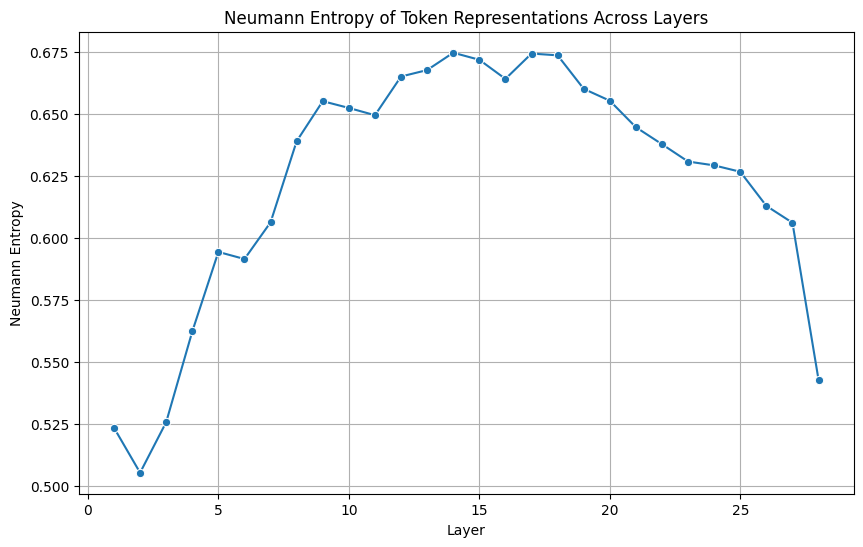

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(entropy_list[:])), y=entropy_list[:], marker="o")
plt.title("Neumann Entropy of Token Representations Across Layers")
plt.xlabel("Layer")
plt.ylabel("Neumann Entropy")
plt.grid(True)
plt.show()

/tmp/ipykernel_235861/3425549395.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_token_before_wo_wait = torch.load("tmp.pt")
100%|██████████| 29/29 [00:01<00:00, 15

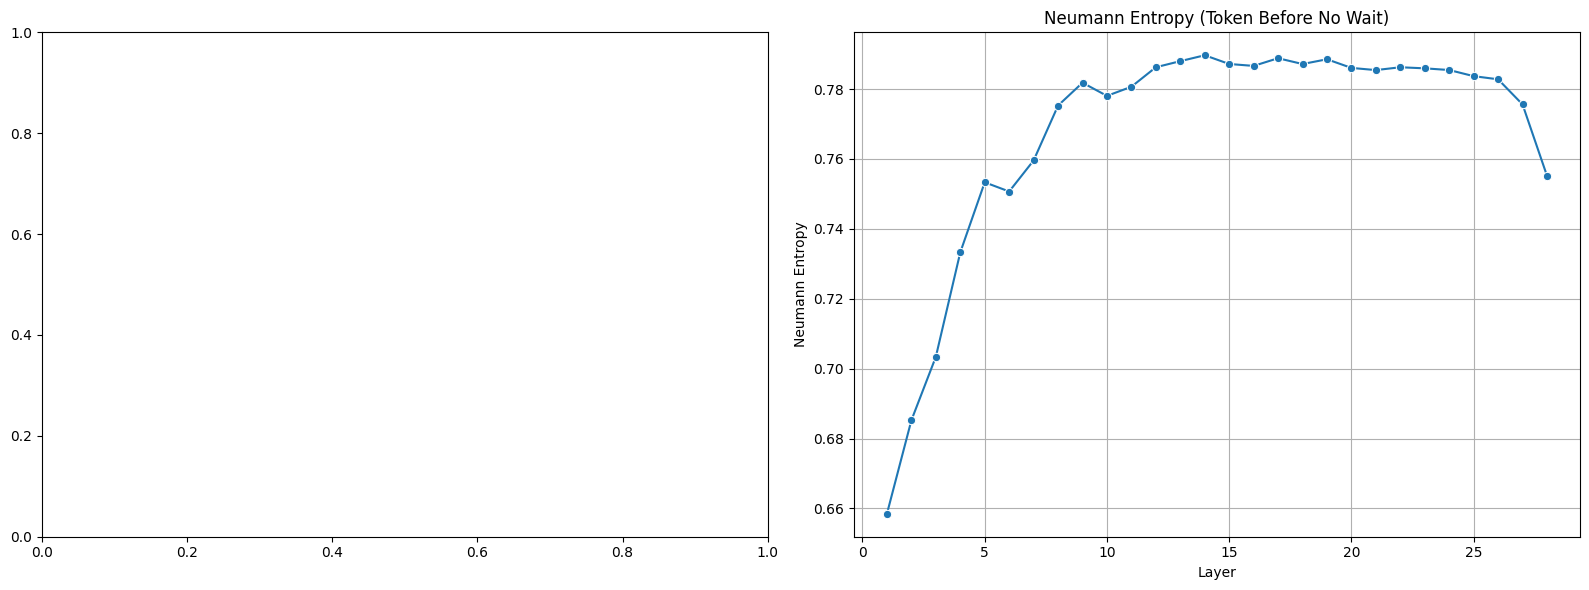

In [6]:
last_token_before_wo_wait = torch.load("tmp.pt")
rank_list = []
entropy_list_no_wait = []
layers = 29
for layer in tqdm(range(layers)):
    token_before_wait = torch.cat([
        x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
        for x in last_token_before_wo_wait
    ]).squeeze().to("cuda:0").to(torch.float32)
    if token_before_wait.shape[0] > 1000:
        indices = torch.randperm(token_before_wait.shape[0])[:1000]
        token_before_wait = token_before_wait[indices]
    neumann = neumann_entropy(token_before_wait)
    entropy_list_no_wait.append(neumann.item())
    # rank_list.append(rank.item())
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# sns.lineplot(ax=axes[0], x=range(len(entropy_list)), y=entropy_list, marker="o")
# axes[0].set_title("Neumann Entropy (Token Before Wait)")
# axes[0].set_xlabel("Layer")
# axes[0].set_ylabel("Neumann Entropy")
# axes[0].grid(True)

sns.lineplot(ax=axes[1], x=range(len(entropy_list_no_wait)), y=entropy_list_no_wait, marker="o")
axes[1].set_title("Neumann Entropy (Token Before No Wait)")
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Neumann Entropy")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
layer = 15
token_before_wait = torch.cat([
    x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
    for x in last_token_before_wait
]).squeeze().to("cuda:0").to(torch.float32)
s = torch.linalg.svdvals(normalized_empirical_covariance(token_before_wait))
s[:10]

tensor([1252.8685,  646.3193,  400.9158,  329.7506,  292.3646,  269.0746,
         255.2202,  243.1849,  213.4971,  210.3027], device='cuda:0')

In [ ]:
layer = 26
token_before_wait = torch.cat([
    x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
    for x in last_token_before_wait
]).squeeze().to("cuda:0").to(torch.float32)
s = torch.linalg.svdvals(normalized_empirical_covariance(token_before_wait))
s[:10]

tensor([15519.9678, 11525.5400,  7127.9541,  6482.9028,  5751.8105,  5333.9141,
         4943.6455,  4404.6602,  3818.8813,  3598.8408], device='cuda:0')

In [ ]:
layer = 27
token_before_wait = torch.cat([
    x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
    for x in last_token_before_wait
]).squeeze().to("cuda:0").to(torch.float32)
s = torch.linalg.svdvals(normalized_empirical_covariance(token_before_wait))
s[:10]

tensor([23963.6973, 17424.1797, 12507.3369, 10349.7568,  7954.5981,  7052.4316,
         6616.2056,  6153.9355,  5060.8682,  4773.8799], device='cuda:0')

In [ ]:
layer = 28
token_before_wait = torch.cat([
    x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
    for x in last_token_before_wait
]).squeeze().to("cuda:0").to(torch.float32)
s = torch.linalg.svdvals(normalized_empirical_covariance(token_before_wait))
s[:10]

tensor([7082.9727,  746.0417,  388.1310,  310.0385,  227.5616,  184.2365,
         156.1815,  140.9657,  134.2803,  118.6508], device='cuda:0')

# Numerical Rank


In [ ]:
last_token_before_wo_wait = torch.load("tmp.pt")

/tmp/ipykernel_231524/1959472152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_token_before_wo_wait = torch.load("tmp.pt")


In [ ]:
last_token_before_wait = torch.load("last_token_before_wait2.pt")

/tmp/ipykernel_231524/601565121.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_token_before_wait = torch.load("last_token_before_wait2.pt")


In [ ]:
len(last_token_before_wo_wait)

9689

In [ ]:
def numerical_rank(A):
    # Compute singular values
    singular_values = torch.linalg.svdvals(A)
    singular_values = singular_values / singular_values.sum()
    # Compute the numerical rank formula
    num_rank = (singular_values.sum() ** 2) / (singular_values.square().sum())
    
    return num_rank

100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


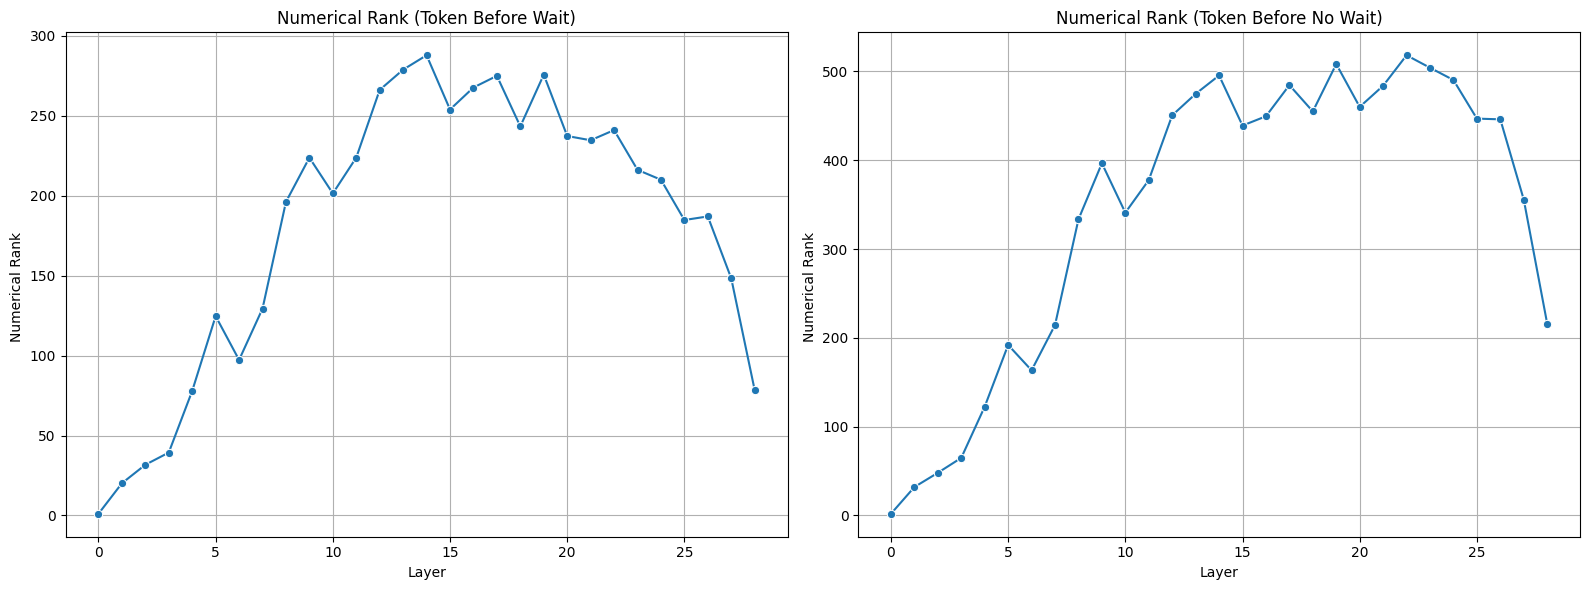

In [ ]:
rank_list = []
layers = 29
numerical_ranks = []
numerical_ranks_no_wait = []
for layer in tqdm(range(layers)):
    token_before_wait = torch.cat([
        x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
        for x in last_token_before_wait
    ]).squeeze().to("cuda:0").to(torch.float32)
    token_before_no_wait = torch.cat([
        x[layer].mean(dim=1, keepdim=True) if x[layer].shape[1] > 1 else x[layer]
        for x in last_token_before_wo_wait
    ]).squeeze().to("cuda:0").to(torch.float32)
    # indices = torch.randperm(token_before_no_wait.shape[0])[:1982]
    # token_before_no_wait = token_before_no_wait[indices]
    rank = numerical_rank(token_before_wait)
    numerical_ranks.append(rank.item())
    rank_no_wait = numerical_rank(token_before_no_wait)
    numerical_ranks_no_wait.append(rank_no_wait.item())
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=range(len(numerical_ranks_no_wait)), y=numerical_ranks_no_wait, marker="o", label="Numerical Rank (Token Before no Wait)")
# plt.title("Numerical Rank Across Layers")
# plt.xlabel("Layer")
# plt.ylabel("Numerical Rank")
# plt.legend()
# plt.grid(True)
# plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(ax=axes[0], x=range(len(numerical_ranks)), y=numerical_ranks, marker="o")
axes[0].set_title("Numerical Rank (Token Before Wait)")
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Numerical Rank ")
axes[0].grid(True)

sns.lineplot(ax=axes[1], x=range(len(numerical_ranks_no_wait)), y=numerical_ranks_no_wait, marker="o")
axes[1].set_title("Numerical Rank (Token Before No Wait)")
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Numerical Rank ")
axes[1].grid(True)

plt.tight_layout()
plt.show()

| Performance | Layer |
|------------|-------|
| 80.1     | 7     |
| 87.1        | 13     |
|  86.4       | 19     |
|  82.6       | 25     |
| 76.0        | 29     |
| 90.2        | None     |

Over self-reflection if when inject in the last layer

Wait a minute, that's \\( a_7 = a_1 (3 r_1 - 2)^2 \\). But earlier, from the sequence, \\( a_7 \\) was built as \\( a_6 + d_3 \\), and \\( a_6 = a_1 (2 r_1 - 1)(3 r_1 - 2) \\). Let me compute \\( a_7 \\) from the arithmetic sequence:\n\nFrom the arithmetic sequence for k=3: \\( a_6, a_7, a_8 \\). So, \\( a_7 = a_6 + d_3 \\)\n\nBut \\( d_3 = a_6 (r_3 - 1) \\). Wait, \\( d_3 = a_{2k} (r_{k+1} - 1) \\), where k=3: \\( d_3 = a_6 (r_4 - 1) \\). Wait, no, wait.\n\nWait, for k=3, the arithmetic sequence is \\( a_6, a_7, a_8 \\). So, \\( a_7 = a_6 + d_3 \\), and \\( d_3 = a_6 (r_4 - 1) \\)\n\nWait, no, that's not right.